## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось


## Важно 2 (0 - 0.15 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.



## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. 
В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например дополнительные лоссы для стабилизации, WGAN-GP, а не GAN/WGAN+clip)


In [1]:
import numpy as np
import torchvision

import torch
from torch import nn
from torch.nn import functional as F

from tqdm.notebook import tqdm
from IPython.display import clear_output


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import requests

# def download_file_from_google_drive(id, destination):
#     def get_confirm_token(response):
#         for key, value in response.cookies.items():
#             if key.startswith('download_warning'):
#                 return value

#         return None

#     def save_response_content(response, destination):
#         CHUNK_SIZE = 32768

#         with open(destination, "wb") as f:
#             for chunk in response.iter_content(CHUNK_SIZE):
#                 if chunk: # filter out keep-alive new chunks
#                     f.write(chunk)

#     URL = "https://docs.google.com/uc?export=download"

#     session = requests.Session()

#     response = session.get(URL, params = { 'id' : id }, stream = True)
#     token = get_confirm_token(response)

#     if token:
#         params = { 'id' : id, 'confirm' : token }
#         response = session.get(URL, params = params, stream = True)

#     save_response_content(response, destination)    


# download_file_from_google_drive('1F96x4LDbsTZGMMq81fZr7aduJCe8N95O', 'celeba.zip')

In [3]:
%enable_full_walk

In [4]:
# import zipfile
# with zipfile.ZipFile('celeba.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

В этом домашнем задании мы будем работать с Celeba. Celeba - это уже известный вам датасет состоящий из фотографий селеб в их привычной местности:

In [5]:
from pytorch_lightning import Trainer, LightningDataModule
from pytorch_lightning.loggers import WandbLogger
import model as m

In [6]:
image_size=(128, 128)
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [7]:
class CelebaDataModule(LightningDataModule):

    def __init__(self, data_dir: str = "celeba", batch_size: int = 64, num_workers: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage = None):
        self.celeba = torchvision.datasets.CelebA('celeba', target_type='attr', transform=transforms, target_transform=lambda l: l.float(), download=False)
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(self.celeba, lengths=[len(self.celeba) - 500, 500])

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, self.batch_size, shuffle=False, num_workers=self.num_workers)


celeba = CelebaDataModule()

In [8]:
attrs = '5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young'
index2attr = {i:j for i, j in enumerate(attrs)}

In [9]:
from importlib import reload

In [16]:
reload(m)

<module 'model' from '/home/jupyter/work/resources/DeepGenerativeModels/homework/2-GAN/model.py'>

In [11]:
images, labels = [], []
for i, (image, label) in zip(range(5), torchvision.datasets.CelebA('celeba', target_type='attr', transform=transforms, target_transform=lambda l: l.float(), download=False)):
    images.append(image.unsqueeze(0))
    labels.append(label.unsqueeze(0))
images, labels = torch.cat(images, 0), torch.cat(labels, 0)

In [13]:
#!XL
trainer = Trainer(logger=WandbLogger(project='GAN-homework_2-GAN', save_dir=None), log_every_n_steps=20, gpus=-1, accelerator='dp')
model__ = m.VanillaStarGAN(images, labels, index2attr)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [14]:
#!XL
__spec__ = None
trainer.fit(model__, datamodule=celeba)

/home/jupyter/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: penchekrak (use `wandb login --relogin` to force relogin)



  | Name          | Type          | Params
------------------------------------------------
0 | discriminator | Discriminator | 45.0 M
1 | generator     | Generator     | 8.5 M 
------------------------------------------------
53.6 M    Trainable params
0         Non-trainable params
53.6 M    Total params
214.356   Total estimated model params size (MB)


AttributeError: 'NoneType' object has no attribute 'val_dataloader'

In [33]:
#!XL
reload(m)

<module 'model' from '/home/jupyter/work/resources/DeepGenerativeModels/homework/2-GAN/model.py'>

In [31]:
#!XL
model__.cpu()

VanillaStarGAN(
  (discriminator): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
      (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.01)
      (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): LeakyReLU(negative_slope=0.01)
    )
    (conv1): Conv2d(2048, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(2048, 40, kernel_size=(2, 2), stride=(1, 1), bias=False)
  )
  (generator): Gener

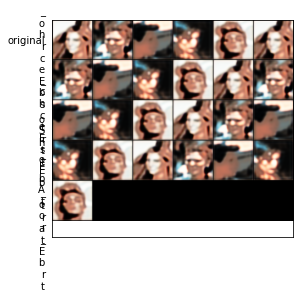

In [34]:
#!XL
model__.generate_images(model__.control_images, model__.desired_labels)

In [26]:
#!XL
%debug

> /usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py(416)_conv_forward()
    414                             _pair(0), self.dilation, self.groups)
    415         return F.conv2d(input, weight, self.bias, self.stride,
--> 416                         self.padding, self.dilation, self.groups)
    417 
    418     def forward(self, input: Tensor) -> Tensor:



ipdb>  input.device


device(type='cuda', index=0)


ipdb>  input


tensor([[[[ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9608,  0.9922],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9922,  0.9765,  1.0000],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9608,  0.9843,  0.9922],
          ...,
          [ 0.3961,  0.3098,  0.1294,  ..., -0.2078, -0.2314, -0.2471],
          [ 0.0902,  0.0667,  0.2235,  ..., -0.0745, -0.0824, -0.0902],
          [ 0.2471,  0.5137,  0.7098,  ..., -0.0745, -0.0667, -0.0667]],

         [[ 0.8118,  0.8118,  0.8118,  ...,  0.8431,  0.8196,  0.8667],
          [ 0.8118,  0.8118,  0.8118,  ...,  0.8510,  0.8431,  0.8745],
          [ 0.8118,  0.8118,  0.8118,  ...,  0.8275,  0.8510,  0.8667],
          ...,
          [-0.1216, -0.2078, -0.4039,  ..., -0.7098, -0.7333, -0.7412],
          [-0.4353, -0.4588, -0.3176,  ..., -0.6078, -0.6078, -0.6078],
          [-0.2863, -0.0196,  0.1608,  ..., -0.6157, -0.6078, -0.6000]],

         [[ 0.5216,  0.5216,  0.5216,  ...,  0.6863,  0.7569,  0.7412],
          [ 0.5216,  0.5216,  

ipdb>  exit


В этой домашней работе вам предлагается повторить результаты статьи StarGAN (https://arxiv.org/abs/1711.09020). 

Основная часть домашнего задания - чтение статьи и улучшение результатов, поэтому обязательно прочитайте не только StarGAN, но и другие Image-to-Image GAN подходы того времени (17-18 год) 


## Задача 1 (0.4 балла):

Повторить результаты StarGAN используя только CelebA

что это значит: в статье предлагается способ использовать несколько датасетов и выучивание аттрибутов уникальных для какого-то одного датасета. Мы не просим вас это делать, вам достаточно просто обучить StarGAN на CelebA

In [ ]:
from model import StarGAN
from utils import permute_labels

model = StarGAN()

In [ ]:
model.train()
for image, label in tqdm(celeba_dataloader, leave=False, desc=f"trainloop: {epoch}"):
    # YOUR CODE

model.eval()
for ind, (image, label) in enumerate(celeba_val_dataloader): # batch = 1
    if ind >= 10: break

    # пример сравнения качества на глаз:
    new_label = permute_labels(label)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow((image[0].permute(1, 2, 0) + 1) / 2)
    plt.subplot(1, 2, 2)
    fake_image = model.generate(image.to(device), new_label.to(device)).detach().cpu()[0]
    plt.imshow((fake_image.permute(1, 2, 0) + 1) / 2)
    plt.show()


## Важно 4: 

Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что трансформации выучились

Еще, кажется что не все аттрибуты селебы являются очень важными или достаточно представленными в датасете. Не запрещается убирать бесполезные аттрибуты (только обоснуйте почему так сделали в отчете)

Не забывайте про аугментации

## Важно 5: 

Да, мы знаем что в на гитхабе лежить готовый код на путорче для этой статьи. Проблема в том что он написал на torch 0.4, поэтому, если мы увидим что вы используете __старый__ код со старыми модулями, то мы:

1. Будем неодобрительно смотреть
2. За наглое списывание будем снимать баллы


## Задача 2 (0.2 балла): 

Мерить качество на глаз - плохая идея. Подключите подсчет FID для каждой N эпохи, чтобы вы могли следить за прогрессом модели.

Сранение моделей между собой тоже возможно только по FID, поэтому трекайте его когда будете делать другие эксперименты

## Задача 3 (0.4 балла):

Если вы будете дословно повторять архитектуру авторов статьи, вы сразу же увидите что обучение станет дико долгим и не очень стабильным. Возможно у вас получится предложить несколько улучшений, которые приведут к хорошему FID, к визуально лучшим результатам или к более стабильному обучению.

В этой задаче хочется чтобы вы попробовали улучшить результаты статьи используя либо то что уже знаете, либо что-то из релевантных статей по Im2Im современности

## Важно 6: 

Когда вы будете показывать визуальные трансформации которые делает ваш StarGAN, хорошей идеей будет сразу же зафиксировать набор картинок (очевидно из валидации) и набор трансформаций на которых вы будете показывать результаты. Например: 10 картинок разных людей на которых вы покажете Male-Female, Beard-noBeard, Old-Young трансформации

## Важно 7 (0.15 балла): 

Выдам дополнительные баллы если у вас получится визуально красивая перекраска волос в разные цвета